# Pneumonia diagnosis software
<hr>

Data can either be downloaded from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia or by using Kaggle API

### Importing libraries & loading data

In [1]:
import numpy as np
import pandas as pd
import os
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Model
from keras.layers import MaxPooling2D, Dropout, Flatten, BatchNormalization, Dense
from keras.optimizers import Adam 
from sklearn.utils import class_weight
from keras.models import load_model
from keras.applications import vgg16
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
os.environ['KAGGLE_USERNAME'] = 'xxx'
os.environ['KAGGLE_KEY'] = 'xxx'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

Using TensorFlow backend.


Images in validation folder should actually be the test data, as it only contains 16 images. Hence, image paths were swapped for validation and test data.


In [0]:
# Image directories

training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

In [0]:
# Class paths from training data

train_dir_pneu = training_dir+'/PNEUMONIA'
train_dir_norm = training_dir+'/NORMAL'

## Visualization

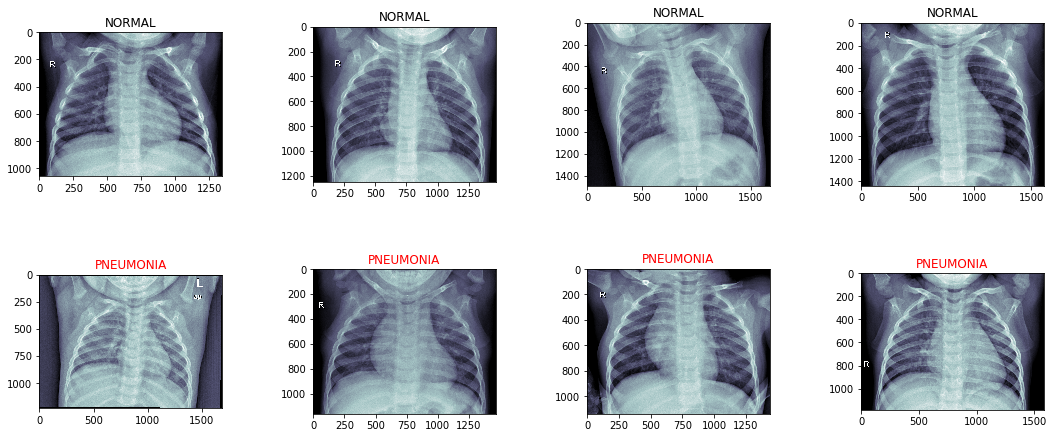

In [4]:
fig = plt.figure(figsize=(18, 8))
plt.subplots_adjust(wspace=.5)

for i in range(1,9):
  if i<5:
    plt.subplot(2,4,i).set_title('NORMAL')
  else:
    plt.subplot(2,4,i).set_title('PNEUMONIA', color='red')

  plt.imshow(mpimg.imread(train_dir_norm+'/'+os.listdir(train_dir_norm)[i],train_dir_pneu+'/'+os.listdir(train_dir_pneu)[i]), cmap='bone')

## Preprocessing

Rescaling images and data augmentation using Keras ImageDataGenerator.

In [5]:
target_size = (200,200)
batch_size = 32
class_mode = 'categorical'
rescale = 1.0/255.0

train_datagen = ImageDataGenerator(
    rescale = rescale,
    shear_range = .2,
    zoom_range = .2,
    width_shift_range = .1,
    height_shift_range = .1,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Model Training

In [0]:
# Weight balancing for the classes

def get_weight(y):
  class_weights = class_weight.compute_class_weight('balanced',np.unique(y), y)
  return class_weights

class_weight=get_weight(train_generator.classes)

In [0]:
def get_model():
  base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))
  x = base.output
  x = MaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu', activity_regularizer=regularizers.l2(10e-8))(x)
  x = Dropout(.25)(x)
  x = Dense(512, activation = 'relu')(x)
  x = Dropout(.25)(x)
  pred = Dense(2, activation='sigmoid')(x)
  
  model=Model(inputs=base.input, outputs=pred)
  
  for layer in base.layers:
    layer.trainable = False
    
  model.summary()
  return model

In [0]:
model = get_model()

In [0]:
nb_epoch=40
lr=10e-7

model.compile(optimizer=Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=10e-10
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=256,
    epochs=nb_epoch,
    verbose=1,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weight,
    callbacks=[checkpointer, early_stopping, reduce_lr]
)

In [0]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss: ', result[0])
print('Accuracy: ', result[1])

In [0]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper_right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [8]:
model=load_model('models/model.h5')
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________

In [9]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss: ', result[0])
print('Accuracy: ', result[1])

16/16 [==============================] - 2s 135ms/step
Loss:  0.4401687995705288
Accuracy:  0.8125


## Prediction

In [0]:
y_pred_batches = []
y_true_batches = []

for i in range(len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

In [0]:
def predict_images(path, rows, cols):
  amt=0
  fig = plt.figure(figsize=(18,8))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amt==(rows*cols):
        break
      plt.subplot(rows, cols, amt+1)
      plt.subplots_adjust(hspace=.5)
      img = mpimg.imread(os.path.join(path, file))
      if y_pred_batches[amt]==y_true_batches[amt]:
        plt.title('{} ---> {}'.format('NORMAL' if y_true_batches[amt] == 0 else 'PNEUMONIA','NORMAL' if y_pred_batches[amt] == 0 else 'PNEUMONIA'))
      else:
        plt.title('{} ---> {}'.format('NORMAL' if y_true_batches[amt] == 0 else 'PNEUMONIA', 'NORMAL' if y_pred_batches[amt] == 0 else 'PNEUMONIA'), color='red')
      plt.imshow(img, cmap='bone')
      
      amt += 1

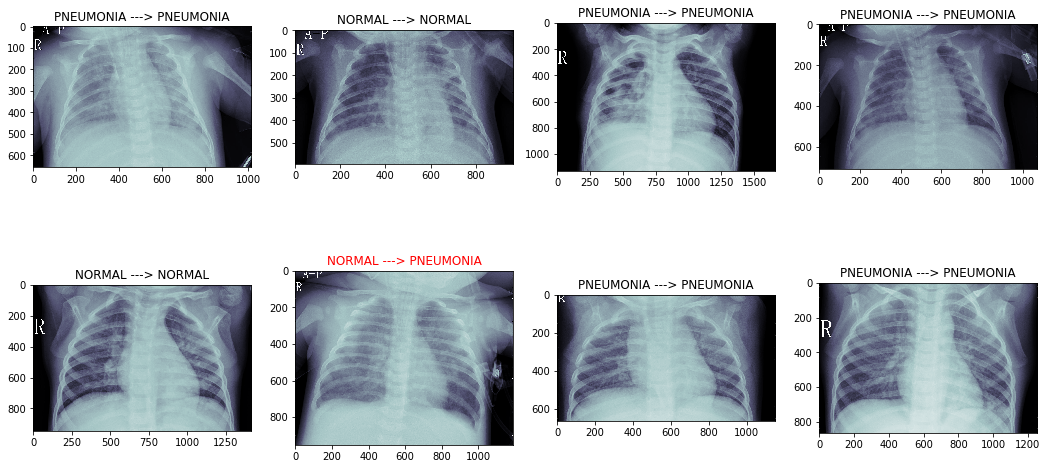

In [12]:
predict_images(test_dir+'/PNEUMONIA', rows=2, cols=4)

## Evaluation

In [13]:
classification_report(y_true=y_true_batches, y_pred=y_pred_batches, target_names=['NORMAL', 'PNEUMONIA'], output_dict=True)

{'NORMAL': {'f1-score': 0.7692307692307693,
  'precision': 1.0,
  'recall': 0.625,
  'support': 8},
 'PNEUMONIA': {'f1-score': 0.8421052631578948,
  'precision': 0.7272727272727273,
  'recall': 1.0,
  'support': 8},
 'accuracy': 0.8125,
 'macro avg': {'f1-score': 0.805668016194332,
  'precision': 0.8636363636363636,
  'recall': 0.8125,
  'support': 16},
 'weighted avg': {'f1-score': 0.805668016194332,
  'precision': 0.8636363636363636,
  'recall': 0.8125,
  'support': 16}}

In [14]:
confusion_matrix(y_true=y_true_batches, y_pred=y_pred_batches)

array([[5, 3],
       [0, 8]])